<a href="https://colab.research.google.com/github/Tobistor/Credit-Card-Fraud-Detection/blob/main/Credit_Card_Fraud_Project_LogisticRegression_Explored.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Credit Card Fraud Detection Project

# Import Libraries and Data

In [22]:
import os 
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.svm import LinearSVC, SVC
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import svm
RFC_METRIC = 'gini' #metrics used for RandomForestClasifier
NUM_ESTIMATORS = 100 #number of estimators used for RandomForestClassifier
NO_JOBS = 4 #number of parallel jobs used for RandomForestClassifier
VALID_SIZE = 0.20 # simple validation using train_test_split
TEST_SIZE = 0.20 # test size using_train_test_split
#Train/validation/test split
#VALIDATION
VALID_SIZE = 0.20 # simple validation using train_test_split
TEST_SIZE = 0.20 # test size using_train_test_split

#CROSS-VALIDATION
NUMBER_KFOLDS = 5 #number of KFolds for cross-validation

RANDOM_STATE = 2018

MAX_ROUNDS = 1000 #lgb iterations
EARLY_STOP = 50 #lgb early stop
OPT_ROUNDS = 1000 #To be adjusted based on best validation rounds
VERBOSE_EVAL = 50 #Print out metric result

IS_LOCAL = False
from google.colab import drive
drive.mount('/content/drive/')
filename = '/content/drive/MyDrive/Colab_Notebooks/creditcard.csv' 
cc_data = pd.read_csv(filename)
#check the data
#cc_data.head()
#cc_data.tail()
print("CreditCard data provided has rows:",cc_data.shape[0], "columns:", cc_data.shape[1])

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
CreditCard data provided has rows: 284807 columns: 31


# Prepare: Clean and Explore Data

In [23]:
# A glimpse of the data by first 5 rows
cc_data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [24]:
# Remove duplicates if present
cc_data.drop_duplicates(inplace=True)
print("After removing Duplicates, CreditCard data now has rows:",cc_data.shape[0], "columns:", cc_data.shape[1])

After removing Duplicates, CreditCard data now has rows: 283726 columns: 31


Check for missing data

In [25]:
check_for_missing_data = cc_data.isnull().sum()
check_for_missing_data

Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

### Distinguishing Fraud and Non-fraud

In [26]:
fraud = cc_data[cc_data['Class']==1]
normal = cc_data[cc_data['Class']==0]

### To know the count of Fraud and Non-fraud in dataset

In [27]:
print("Fraud:",fraud.shape,"Normal:",normal.shape)

Fraud: (473, 31) Normal: (283253, 31)


### Statistical Exploration of the dataset

In [28]:
fraud.Amount.describe()

count     473.000000
mean      123.871860
std       260.211041
min         0.000000
25%         1.000000
50%         9.820000
75%       105.890000
max      2125.870000
Name: Amount, dtype: float64

In [29]:
normal.Amount.describe()

count    283253.000000
mean         88.413575
std         250.379023
min           0.000000
25%           5.670000
50%          22.000000
75%          77.460000
max       25691.160000
Name: Amount, dtype: float64

### Visual exploration using matplotlib (Histogram Chart)

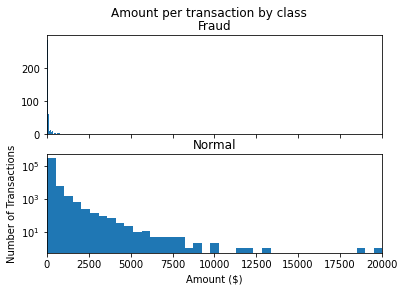

In [30]:
f, (ax1, ax2)=plt.subplots(2,1, sharex=True)
f.suptitle('Amount per transaction by class')
bins = 50
ax1.hist(fraud.Amount, bins = bins)
ax1.set_title('Fraud')
ax2.hist(normal.Amount, bins = bins)
ax2.set_title('Normal')
plt.xlabel('Amount ($)')
plt.ylabel('Number of Transactions')
plt.xlim((0,20000))
plt.yscale('log')
plt.show()

### Visual exploration using matplotlib (Using Scatter plot)

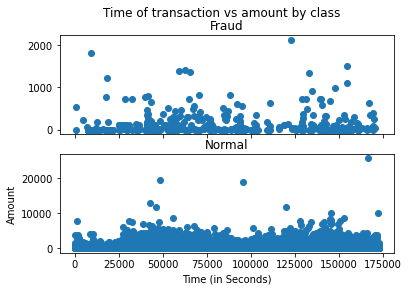

In [31]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
f.suptitle('Time of transaction vs amount by class')
ax1.scatter(fraud.Time, fraud.Amount)
ax1.set_title('Fraud')
ax2.scatter(normal.Time, normal.Amount)
ax2.set_title('Normal')
plt.xlabel('Time (in Seconds)')
plt.ylabel('Amount')
plt.show()

### Taking 90% of entire data for training

In [42]:
#Take 10% of the dataset for training, in order to reduce runtime going forward. 
#This is not advised often. Purpose and context must be considered in future projects
dataset=cc_data.sample(frac = 0.1,random_state=1)
dataset.shape

(28373, 31)

### Determine the number of fraud and valid transactions in the new dataset

In [43]:
Fraud = dataset[dataset['Class']==1]
Valid = dataset[dataset['Class']==0]
outlier_fraction = len(Fraud)/float(len(Valid))

In [44]:
print(outlier_fraction)
print("Fraud Cases : {}".format(len(Fraud)))
print("Valid Cases : {}".format(len(Valid)))

0.001411781315074295
Fraud Cases : 40
Valid Cases : 28333


### Exploration using Heatmap to determine correlation

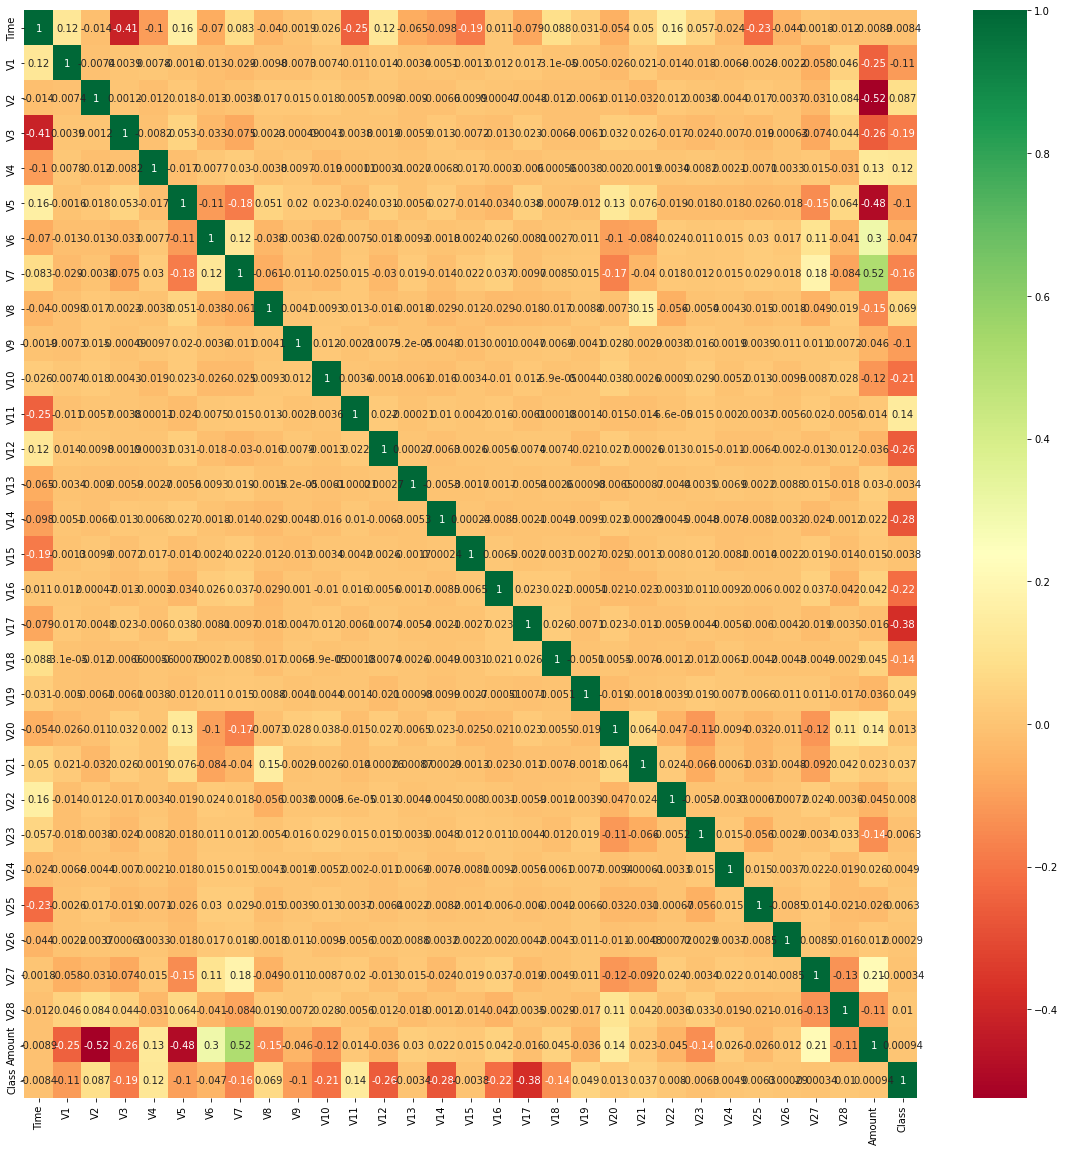

In [45]:
#Correlation
import seaborn as sns
#get correlations of each features in dataset
corrmat = dataset.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(20,20))
#plot heat map
g=sns.heatmap(dataset[top_corr_features].corr(),annot=True,cmap="RdYlGn")

### Define X and Y; Data and Target.

In [46]:
#Build model with all of the data features
target = dataset ['Class']
predictors = dataset [['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',\
             'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19',\
             'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28',\
             'Amount']]

X = predictors #didn't apply .value cos it's already in Numpy array
y = target  #didn't apply .value cos it's already in Numpy array

#Another quick way to create X and y Datasets...
#X = dataset.drop('Class', axis = 1).values
#y = dataset['Class'].values

# Split Train and Test Data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 1)
# Two datasets have now been created, train data we will be used for training our model and the data which is unseen will be used for testing.


### Tune and Build The Linear Regression Model
###### Linear Regression is commonly used to estimate the probabilities that an instance belong to a particular class. Related to this project, it tells what is the probability that a transaction is fraud. If the probability is more than 50%, then the model predicts that the instance belongs to that class otherwise does not belong to that class. It is basically a binary classifier.

#### Hyper Parameter Tuning:
Hyper-parameters are parameters that are not directly learned within estimators. I will be using the **GridSearchCV** for analysis, GridSearchCV considers all the combinations from parameters specified in the parameter grid. Whereas, **RandomizedSearchCV** selects a few candidates from all the combinations.

**Hyperparameters for Logistic Regression:**

**C:** It's a control parameter that controls penalty strength. The higher the value of C, the less the model is regularized

**Solver:** It's useful to try different solvers as they are each solver's performance or convergence is different from others.

**Penalty:** Here we can specify regularization Techniques.

**Max_iter:** Maximum number of iterations taken for the solver to converge



##### Logistic Regression

In [48]:
lr = LogisticRegression()
param_grid = {'penalty' : ['l2', 'none'], 
              'C': np.logspace(-4,4,20),
              'solver' : ['lbfgs','newton-cg','liblinear'],
              'max_iter' : [100, 1000,2500]}

log_with_param = GridSearchCV(lr, param_grid = param_grid, cv = 3, verbose=3, n_jobs=-1)

best_log_with_param = log_with_param.fit(X_train, y_train)
best_log_with_param.best_estimator_

Fitting 3 folds for each of 360 candidates, totalling 1080 fits


LogisticRegression(C=11.288378916846883, max_iter=1000, solver='newton-cg')

The grid search had explored a various combination of Logistic Regression parameters and trained each model 3 times(using 3 fold cross-validation) and after training the model on dataset, the best parameters are:

*LogisticRegression(C=11.288378916846883, max_iter=1000, solver='newton-cg')*